In [1]:
import numpy as np
import pandas as pd
import math
import sklearn.preprocessing
import datetime
from TimeBasedCV import TimeBasedCV
from sklearn.metrics import make_scorer, r2_score
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
import pickle 

import warnings
warnings.simplefilter(action='ignore', category=Warning)
# more

In [2]:
# df = pd.read_csv('factors_2002.csv', parse_dates=['DATE'])

In [3]:

# with open('data/features_1965.pkl', 'wb') as f:
#     pickle.dump(df, f)

with open('data/features_1965.pkl', 'rb') as f:
    df = pickle.load(f)
    print(df.head())



   permno       DATE        mvel1      beta    betasq     chmom     dolvol  \
0   10145 1965-02-26   1498872.00  0.983510  0.967291  0.105988  11.546907   
1   10401 1965-02-26  35392058.00  0.780829  0.609694 -0.063768  12.240330   
2   10786 1965-02-26   1695284.75  0.806119  0.649827 -0.130519  12.005040   
3   10989 1965-02-26   1295887.75  1.199748  1.439395  0.073609  11.756961   
4   11260 1965-02-26   2302001.25  1.257269  1.580725 -0.167320  12.240330   

    idiovol    indmom     mom1m  ...  macro_ep  macro_bm  macro_ntis  \
0  0.022307  0.035075  0.104116  ...  2.936836  0.471399    0.014823   
1  0.013395  0.335139 -0.007326  ...  2.936836  0.471399    0.014823   
2  0.024366  0.104106  0.060498  ...  2.936836  0.471399    0.014823   
3  0.022717  0.118513  0.068807  ...  2.936836  0.471399    0.014823   
4  0.035883  0.185424 -0.036885  ...  2.936836  0.471399    0.014823   

   macro_tbl  macro_tms  macro_dfy  macro_svar  macro_mkt-rf  macro_hml  \
0     0.0393    -0.0379

In [4]:
#Sort observations by date and stock id
df[df.columns[2:]] = df[df.columns[2:]].astype('float32')
df = df.sort_values(by = ['DATE', 'permno'], ascending = True)
df.head()


,permno,DATE,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,macro_ep,macro_bm,macro_ntis,macro_tbl,macro_tms,macro_dfy,macro_svar,macro_mkt-rf,macro_hml,macro_smb
0,10145,1965-02-26,1498872.00,0.983510,0.967291,0.105988,11.546906,0.022307,0.035075,0.104116,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
1,10401,1965-02-26,35392056.00,0.780829,0.609694,-0.063768,12.240331,0.013395,0.335139,-0.007326,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
2,10786,1965-02-26,1695284.75,0.806119,0.649827,-0.130519,12.005040,0.024366,0.104106,0.060498,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
3,10989,1965-02-26,1295887.75,1.199748,1.439395,0.073609,11.756961,0.022717,0.118513,0.068807,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55
4,11260,1965-02-26,2302001.25,1.257269,1.580725,-0.167320,12.240331,0.035883,0.185424,-0.036885,...,2.936836,0.471399,0.014823,0.0393,-0.0379,0.0055,0.000393,0.44,0.11,3.55


In [5]:
df['permno2'] = df['permno'].copy()
df['DATE2'] = df['DATE'].copy()
df = df.set_index(['DATE2','permno2'])

#Make a copy of  the "me" variable (market equity) before rank standartization to use afterwards for value weighting
df['mvel12'] = df['mvel1'].copy()

In [6]:
p=0.3 
df_large= df.groupby('DATE').apply(lambda x: x.nlargest(int(len(x)*p),'mvel1')).reset_index(drop=True)  
df_small = df.groupby('DATE').apply(lambda x: x.nsmallest(int(len(x)*p),'mvel1')).reset_index(drop=True)  


In [7]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium'])].tolist()
df[features]=df.groupby('DATE')[features].rank(pct=True)
df[features] = 2*df[features] - 1

df_large[features]=df_large.groupby('DATE')[features].rank(pct=True)
df_large[features] = 2*df_large[features] - 1

df_small[features]=df_small.groupby('DATE')[features].rank(pct=True)
df_small[features] = 2*df_small[features] - 1

In [8]:
tscv = TimeBasedCV(train_period=180,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df[features]
y = df[['risk_premium']]

#Empty containers to save results from each window

#Empty containers to save results from each window
predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}

# Model’s complexity: dictionary to save the number of components over time
numpc_time = {}

# List of prespecified values to use to determine the optimal number of components 
numpc =np.arange(1, 35, 1).tolist()
# Empty container to save the objective loss function (mean squared errors) for each number of components
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)

for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1981,1,31), second_split_date= datetime.date(1991,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    #Loop over the list containing potential number of components, fit on the training sample and use 
    #validation set to generate predictions
    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        #predictions are transformed into 1D array 
        Yval_predict = Yval_predict.ravel()
        #calculate mean squared error for each potential value of the numpc hyperparameter
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))
      
    #The optimal value of the numpc hyperparameter is the value that causes the lowest loss
    optim_numpc = numpc[np.argmin(mse)]
    
    #Fit again using the train and validation set and the optimal numpc parameter
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    #Use test set to generate final predictions
    preds = pls.predict(X_test)
    #predictions are transformed into 1D array 
    preds = preds.ravel()

    #Save predictions, dates and the true values of the dependent variable to list  
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    #Calculate OOS model performance the for current window
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    #Save OOS model performance and the respective month to dictionary
    dic_r2_all["r2." + str(y_test.index)] = r2
    # Save the number of components to inspect  model's complexity over time 
    numpc_time["numpc." + str(y_test.index)] = optim_numpc
        
#Concatenate to get results over the whole OOS test period (Jan 2010-Dec 2019)
predictions_all= np.concatenate(predictions, axis=0)
y_test_list_all= np.concatenate(y_test_list, axis=0) 
dates_all= np.concatenate(dates, axis=0)

#Calculate OOS model performance over the entire test period in line with Gu et al (2020)
R2OOS_PLS = r2_score(y_test_list_all, predictions_all)
print("R2OOS partial least squares: ", R2OOS_PLS)

Train period: 1966-01-31 - 1981-01-31 ,val period: 1981-01-31 - 1983-01-31 , Test period 1983-01-31 - 1984-01-31 # train records 25864 ,# val records 6471 , # test records 4416
Train period: 1967-01-31 - 1982-01-31 ,val period: 1982-01-31 - 1984-01-31 , Test period 1984-01-31 - 1985-01-31 # train records 28359 ,# val records 7309 , # test records 4368
Train period: 1968-01-31 - 1983-01-31 ,val period: 1983-01-31 - 1985-01-31 , Test period 1985-01-31 - 1986-01-31 # train records 30036 ,# val records 8784 , # test records 4870
Train period: 1969-01-31 - 1984-01-31 ,val period: 1984-01-31 - 1986-01-31 , Test period 1986-01-31 - 1987-01-31 # train records 33152 ,# val records 9238 , # test records 6416
Train period: 1970-01-31 - 1985-01-31 ,val period: 1985-01-31 - 1987-01-31 , Test period 1987-01-31 - 1988-01-31 # train records 36021 ,# val records 11286 , # test records 6641
Train period: 1971-01-31 - 1986-01-31 ,val period: 1986-01-31 - 1988-01-31 , Test period 1988-01-31 - 1989-01-31 #

In [9]:
tscv = TimeBasedCV(train_period=180,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'sic2', 'DATE2', 'risk_premium'])].tolist()

X = df_large[features]
y = df_large[['risk_premium']]

#Empty containers to save results from each window

predictions_top = []
y_test_list_top =[]
dates_top = []
dic_r2_all_top = {}

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1981,1,31), second_split_date= datetime.date(1991,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

    optim_numpc = numpc[np.argmin(mse)]
    
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(X_test)

    predictions_top.append(preds)
    dates_top.append(y_test.index)
    y_test_list_top.append(y_test)
    
  
    r2 = 1-np.sum(pow(y_test-preds,2))/np.sum(pow(y_test,2))
    dic_r2_all_top["r2." + str(y_test.index)] = r2


predictions_all_top= np.concatenate(predictions_top, axis=0)
y_test_list_all_top= np.concatenate(y_test_list_top, axis=0) 
dates_all_top= np.concatenate(dates_top, axis=0)

R2TOP = r2_score(y_test_list_all_top, predictions_all_top)
R2TOP

Train period: 1966-01-31 - 1981-01-31 ,val period: 1981-01-31 - 1983-01-31 , Test period 1983-01-31 - 1984-01-31 # train records 7676 ,# val records 1930 , # test records 1320
Train period: 1967-01-31 - 1982-01-31 ,val period: 1982-01-31 - 1984-01-31 , Test period 1984-01-31 - 1985-01-31 # train records 8425 ,# val records 2182 , # test records 1304
Train period: 1968-01-31 - 1983-01-31 ,val period: 1983-01-31 - 1985-01-31 , Test period 1985-01-31 - 1986-01-31 # train records 8928 ,# val records 2624 , # test records 1458
Train period: 1969-01-31 - 1984-01-31 ,val period: 1984-01-31 - 1986-01-31 , Test period 1986-01-31 - 1987-01-31 # train records 9864 ,# val records 2762 , # test records 1919
Train period: 1970-01-31 - 1985-01-31 ,val period: 1985-01-31 - 1987-01-31 , Test period 1987-01-31 - 1988-01-31 # train records 10724 ,# val records 3377 , # test records 1987
Train period: 1971-01-31 - 1986-01-31 ,val period: 1986-01-31 - 1988-01-31 , Test period 1988-01-31 - 1989-01-31 # trai

0.007886938811567545

In [10]:
tscv = TimeBasedCV(train_period=180,
                   val_period=24,
                   test_period=12,
                   freq='months')

features = df.columns[~df.columns.isin(['permno', 'permno2', 'mvel12', 'DATE2', 'risk_premium'])].tolist()

X = df_small[features]
y = df_small[['risk_premium']]

predictions_bottom = []
y_test_list_bottom =[]
dates_bottom = []
dic_r2_all_bottom = {}

numpc =np.arange(1, 35, 1).tolist()
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)


for train_index, val_index, test_index in tscv.split(X, first_split_date= datetime.date(1981,1,31), second_split_date= datetime.date(1991,1,31)):

    X_train   = X.loc[train_index].drop('DATE', axis=1)
    y_train = y.loc[train_index]
    
    X_val   = X.loc[val_index].drop('DATE', axis=1)
    y_val = y.loc[val_index]

    X_test    = X.loc[test_index].drop('DATE', axis=1)
    y_test  = y.loc[test_index]
    
    for i in range(len(numpc)):
        pls_val = PLSRegression(n_components = numpc[i], scale = False)
        pls_val.fit(X_train, y_train)
        Yval_predict=pls_val.predict(X_val)
        Yval_predict = Yval_predict.ravel()
        mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

    optim_numpc = numpc[np.argmin(mse)]
    
    pls = PLSRegression(n_components=optim_numpc, scale = False)
    pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
    preds = pls.predict(X_test)
    preds = preds.ravel()

    predictions_bottom.append(preds)
    dates_bottom.append(y_test.index)
    y_test_list_bottom.append(y_test)
    
  
    r2 = 1-np.sum(pow(y_test['risk_premium']-preds,2))/np.sum(pow(y_test['risk_premium'],2))
    dic_r2_all_bottom["r2." + str(y_test.index)] = r2


predictions_all_bottom= np.concatenate(predictions_bottom, axis=0)
y_test_list_all_bottom= np.concatenate(y_test_list_bottom, axis=0) 
dates_all_bottom= np.concatenate(dates_bottom, axis=0)

R2BOTTOM = r2_score(y_test_list_all_bottom, predictions_all_bottom)
R2BOTTOM

Train period: 1966-01-31 - 1981-01-31 ,val period: 1981-01-31 - 1983-01-31 , Test period 1983-01-31 - 1984-01-31 # train records 7676 ,# val records 1930 , # test records 1320
Train period: 1967-01-31 - 1982-01-31 ,val period: 1982-01-31 - 1984-01-31 , Test period 1984-01-31 - 1985-01-31 # train records 8425 ,# val records 2182 , # test records 1304
Train period: 1968-01-31 - 1983-01-31 ,val period: 1983-01-31 - 1985-01-31 , Test period 1985-01-31 - 1986-01-31 # train records 8928 ,# val records 2624 , # test records 1458
Train period: 1969-01-31 - 1984-01-31 ,val period: 1984-01-31 - 1986-01-31 , Test period 1986-01-31 - 1987-01-31 # train records 9864 ,# val records 2762 , # test records 1919
Train period: 1970-01-31 - 1985-01-31 ,val period: 1985-01-31 - 1987-01-31 , Test period 1987-01-31 - 1988-01-31 # train records 10724 ,# val records 3377 , # test records 1987
Train period: 1971-01-31 - 1986-01-31 ,val period: 1986-01-31 - 1988-01-31 , Test period 1988-01-31 - 1989-01-31 # trai

0.00443405310447853

In [11]:
chart = np.array([[R2OOS_PLS],
                  [R2TOP],
                  [R2BOTTOM]])

r2_pls = pd.DataFrame(chart, columns=['PLS Regression'],
                     index=['Full Sample', 'Large Firms', 'Small Firms'])

r2_pls

,PLS Regression
Full Sample,0.005487
Large Firms,0.007887
Small Firms,0.004434


In [85]:
r2_pls.to_csv(r'r2_PLS_model.csv')

In [86]:
features = df.columns[~df.columns.isin(['DATE', 'DATE2', "mvel2",'sic2' ,'permno',"permno2",'risk_premium', 'year'])].tolist()
df['year'] = df['DATE'].dt.year

X_train = df[features].loc[(df["year"]>=2013) & (df["year"]<=2018)]
y_train = df["risk_premium"].loc[(df["year"]>=2013) & (df["year"]<=2018)]

X_val = df[features].loc[(df["year"]>=2018) & (df["year"]<=2020)]
y_val = df["risk_premium"].loc[(df["year"]>=2018) & (df["year"]<=2020)]

numpc =np.arange(1, 35, 1).tolist()
# Empty container to save the objective loss function (mean squared errors) for each number of components
mse = np.full((len(numpc),1),np.nan, dtype = np.float32)

for i in range(len(numpc)):
    pls_val = PLSRegression(n_components = numpc[i], scale = False)
    pls_val.fit(X_train, y_train)
    Yval_predict=pls_val.predict(X_val)
    Yval_predict = Yval_predict.ravel()
    mse[i,0] = np.sqrt(mean_squared_error(y_val, Yval_predict))

optim_numpc = numpc[np.argmin(mse)]
pls = PLSRegression(n_components=optim_numpc, scale = False)
pls.fit(np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)))
preds = pls.predict(np.concatenate((X_train, X_val))) 
preds = preds.ravel()

R2OOS_all = 1-np.sum(pow(np.concatenate((y_train, y_val))-preds,2))/np.sum(pow(np.concatenate((y_train, y_val)),2))
print(R2OOS_all)

0.004864869505123437


In [31]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

results["identifier"]= results["identifier"].astype("str")
results["date"] = results["identifier"].str[12:22]
results["id"] = results["identifier"].str[35:40]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results.head()

# results['yhat'] = results['yhat'].apply(lambda x: x[0])
results['y_true'] = results['y_true'].apply(lambda x: x[0])

data = df[['mvel12', 'macro_tbl', 'macro_svar']].copy()
data.reset_index(inplace=True)
data['permno2'] = data['permno2'].astype('str')
data['MonthYear'] = data['DATE2'].dt.to_period('M')
data.drop('DATE2', axis=1, inplace=True)
data.rename(columns={'permno2': 'id'}, inplace=True)
data.rename(columns={'mvel12': 'market_cap'}, inplace=True)
data.rename(columns={'macro_tbl': 'risk_free_rate'}, inplace=True)
data = data.set_index(['MonthYear','id'])

bigdata = pd.merge(results, data,left_index=True, right_index=True)
bigdata.reset_index(inplace=True)
bigdata.head()
bigdata['returns'] = bigdata['y_true'] + bigdata['risk_free_rate']

In [32]:
bigdata

,MonthYear,id,yhat,y_true,date,market_cap,risk_free_rate,macro_svar,returns
0,1983-01,10137,-8.378168,-8.6263,1983-01-31,-0.729231,0.003077,0.003077,-8.623223
1,1983-01,10145,-6.976784,-1.1502,1983-01-31,-0.710769,0.003077,0.003077,-1.147123
2,1983-01,10161,-9.726968,7.9920,1983-01-31,-0.366154,0.003077,0.003077,7.995077
3,1983-01,10225,-5.060895,-8.6450,1983-01-31,0.329231,0.003077,0.003077,-8.641924
4,1983-01,10233,-8.245877,-14.3907,1983-01-31,-0.070769,0.003077,0.003077,-14.387623
...,...,...,...,...,...,...,...,...,...
620975,2021-01,93393,-0.700842,-5.4710,2021-01-29,-0.964940,0.000398,0.000398,-5.470602
620976,2021-01,93419,-1.093423,-2.4747,2021-01-29,-0.098805,0.000398,0.000398,-2.474302
620977,2021-01,93423,-1.474186,0.2333,2021-01-29,-0.258167,0.000398,0.000398,0.233698
620978,2021-01,93427,-0.200988,1.6799,2021-01-29,-0.267729,0.000398,0.000398,1.680298


In [33]:
bigdata.to_csv('predictions/pls.csv', index=False)

In [34]:
bigdata["MonthYear1"]= bigdata["MonthYear"].copy()
bigdata["MonthYear"]= bigdata["MonthYear"].astype("int64")
bigdata["NumMonth"]= bigdata["MonthYear"] - 155
bigdata["NumMonth"].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [63]:
for i in bigdata['NumMonth'].unique():
    globals()['df_' + str(i)] = bigdata[bigdata['NumMonth'] == i]

for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["rank"]= globals()['df_' + str(i)]['yhat'].rank(method='first')
    
for i in bigdata["NumMonth"].unique():
    globals()['df_' + str(i)]["DecileRank"]=pd.qcut(globals()['df_' + str(i)]['rank'].values, 10, labels = False)

#Drop normal rank, retain only decile ranks 
for i in bigdata["NumMonth"].unique():
     globals()['df_' + str(i)].drop('rank', axis=1, inplace=True)


for i in bigdata["NumMonth"].unique():
    for j,g in globals()['df_' + str(i)].groupby('DecileRank'):
        globals()['df_' + str(i)+ "_" + str(j)] =  g

for j in np.arange(0,10,1):
    globals()['rank_' + str(j)] = pd.concat([globals()['df_1_'+ str(j)], globals()['df_2_'+ str(j)]], axis=0)
    
# Generate 10 Dataframes for the 10 Decile portfolios 0-9: rank_9: top portfolio, rank_0: bottom portfolio
for i in np.arange(2,457,1):
    for j in np.arange(0,10,1):
        globals()['rank_' + str(j)] = pd.concat([globals()['rank_' + str(j)], globals()['df_' + str(i+1)+ "_" + str(j)]], axis = 0)

In [75]:
for j in np.arange(0, 10, 1):
    globals()['rank_' + str(j)] = globals()['rank_' + str(j)].sort_values(['NumMonth', 'yhat'], 
                                    ascending=[True, True]).groupby(['MonthYear'], 
                                                                    as_index=False, sort=False).tail(100)

In [76]:
for j in np.arange(0,10,1):
    globals()['rank_' + str(j)]["eq_weights"] = 1/globals()['rank_' + str(j)].groupby('MonthYear')["id"].transform('size')
    globals()['rank_' + str(j)]['excess_return_stock_ew'] = globals()['rank_' + str(j)]["y_true"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['return_stock_ew'] = globals()['rank_' + str(j)]["returns"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["excess_return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["return_stock_ew"].transform('sum')
    globals()['rank_' + str(j)]['pred_excess_return_stock_ew'] = globals()['rank_' + str(j)]["yhat"]*globals()['rank_' + str(j)]["eq_weights"]
    globals()['rank_' + str(j)]['pred_excess_return_portfolio_ew'] = globals()['rank_' + str(j)].groupby('MonthYear')["pred_excess_return_stock_ew"].transform('sum')

    globals()['montly_rank_' + str(j)] = globals()['rank_' + str(j)][["MonthYear1", "DecileRank",
                                                                      "excess_return_portfolio_ew",
                                                                      "pred_excess_return_portfolio_ew",
                                                                      "return_portfolio_ew"]]

    globals()['montly_rank_' + str(j)]=globals()['montly_rank_' + str(j)].drop_duplicates()

    globals()["ew_mean_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()
    #Time-series average of predicted excess returns
    globals()["ew_mean_pred_return_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["pred_excess_return_portfolio_ew"].mean()
    #Standard deviation of realized excess returns
    globals()["std_ew_rank_" +  str(j)]= globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].std()
    #Annualized sharpe ratio of realized excess returns
    globals()["sharpe_ew_rank_" +  str(j)]= (globals()['montly_rank_' + str(j)]["excess_return_portfolio_ew"].mean()/globals()['montly_rank_' + str(j)]["return_portfolio_ew"].std())* np.sqrt(12)

In [77]:
chart_np = np.array([[ew_mean_pred_return_rank_0, ew_mean_return_rank_0, std_ew_rank_0, sharpe_ew_rank_0],
                     [ew_mean_pred_return_rank_1, ew_mean_return_rank_1, std_ew_rank_1, sharpe_ew_rank_1],
                     [ew_mean_pred_return_rank_2, ew_mean_return_rank_2, std_ew_rank_2, sharpe_ew_rank_2],
                     [ew_mean_pred_return_rank_3, ew_mean_return_rank_3, std_ew_rank_3, sharpe_ew_rank_3],
                     [ew_mean_pred_return_rank_4, ew_mean_return_rank_4, std_ew_rank_4, sharpe_ew_rank_4],
                     [ew_mean_pred_return_rank_5, ew_mean_return_rank_5, std_ew_rank_5, sharpe_ew_rank_5],
                     [ew_mean_pred_return_rank_6, ew_mean_return_rank_6, std_ew_rank_6, sharpe_ew_rank_6],
                     [ew_mean_pred_return_rank_7, ew_mean_return_rank_7, std_ew_rank_7, sharpe_ew_rank_7],
                     [ew_mean_pred_return_rank_8, ew_mean_return_rank_8, std_ew_rank_8, sharpe_ew_rank_8],
                     [ew_mean_pred_return_rank_9, ew_mean_return_rank_9, std_ew_rank_9, sharpe_ew_rank_9]])

ew_df = pd.DataFrame(chart_np, columns=['Pred', 'Real', 'Std', 'Sharpe'],
                              index=['Low (L)', '2', '3', '4', '5','6','7','8',"9",'High (H)'])
ew_df['Pred'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Pred']], index = ew_df.index)
ew_df['Real'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Real']], index = ew_df.index)
ew_df['Std'] = pd.Series(["{0:.2f}%".format(val) for val in ew_df['Std']], index = ew_df.index)
ew_df['Sharpe'] = pd.Series([("%.2f" % round(val, 2)) for val in ew_df['Sharpe']], index = ew_df.index)
ew_df

,Pred,Real,Std,Sharpe
Low (L),-5.26%,-3.09%,6.39%,-1.68
2,-4.94%,-2.91%,6.01%,-1.68
3,-4.75%,-2.81%,5.70%,-1.71
4,-4.61%,-2.68%,5.50%,-1.69
5,-4.47%,-2.67%,5.42%,-1.71
6,-4.35%,-2.65%,5.37%,-1.71
7,-4.21%,-2.56%,5.37%,-1.65
8,-4.06%,-2.60%,5.40%,-1.67
9,-3.88%,-2.51%,5.53%,-1.58
High (H),-3.51%,-2.36%,5.69%,-1.44


<Axes: xlabel='time'>

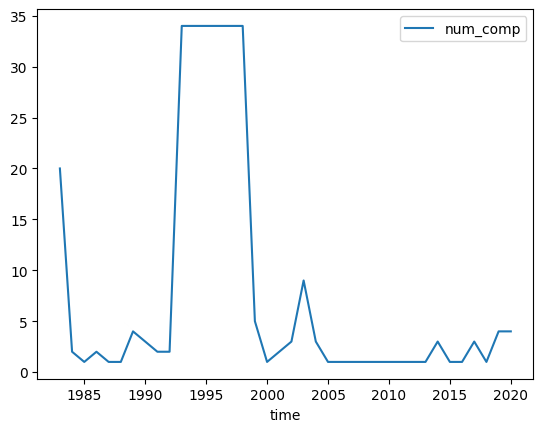

In [13]:
pd.DataFrame(numpc_time.items())
numpc_table = pd.DataFrame(numpc_time.items(), columns=['Identifier', 'num_comp'])
numpc_table['Identifier'] = numpc_table['Identifier'].astype(str)
numpc_table['time'] = numpc_table['Identifier'].str[20:30]
numpc_table['time'] = pd.to_datetime(numpc_table['time'], utc=False)
numpc_table['time'] = numpc_table['time'].dt.year
numpc_table.drop(['Identifier'], axis = 1, inplace=True)

numpc_table.set_index('time').plot()